In [32]:
from tqdm import tqdm_notebook
import SimpleITK as sitk
import numpy as np
import re
from os.path import join
from os import listdir
from random import shuffle, sample

In [33]:
from matplotlib import pyplot as plt
# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()

In [34]:
dataDir = "/projects/0/ismi2018/FINALPROJECTS/BREAST_THOMOSYNTHESIS"

def listCaseIDs(dataRoot):
    cases = [f.replace(".gtrt","") for f in listdir(join(dataRoot,"gtrs")) if ".gtrt" in f]
    return cases

def getPoints(filename,dataRoot):
    annotation = open(filename,"r").read()
    regex = "\[\n[\d* \d* \d*\n+]+"
    prog = re.compile(regex)
    result = prog.findall(annotation)
    
    result = [item for r in result for item in r.split("\n")[1:]]
    result = [[int(c) for c in cords.split()] for cords in result if len(cords.split()) == 3]
    result = np.asarray(result)
    return result

def makeMask(caseID,dataRoot,dims=None):
    anotationFileName = join(dataRoot,"gtrs",caseID+".gtrt")
    points = getPoints(anotationFileName,dataRoot)
    if(dims is None):
        dims = np.max(points,axis=0) + 1
    Mask = np.zeros(dims)
    Mask[points[:,1],points[:,2],points[:,2]] = 1.0
    return Mask

def loadScan(caseID,dataRoot):
    dataFolder = join(dataRoot,"dataset","t" + caseID)
    images = [f for f in listdir(dataFolder) if ".dcm" in f]
    images.sort(key=lambda x: float(x.replace(".dcm","")))
    
    scan = np.zeros(getDims(caseID,dataRoot))
    for i,f in enumerate(images):
        image = sitk.ReadImage ( join(dataFolder,f) )
        scan[:,:,i] = sitk.GetArrayFromImage(image)
    return scan
    
def getDims(caseID,dataRoot):
    dataFolder = join(dataRoot,"dataset","t" + caseID)
    images = [f for f in listdir(dataFolder) if ".dcm" in f]
    image = sitk.ReadImage ( join(dataFolder,images[0]) )
    dims = image.GetSize()
    dims = (dims[1],dims[0],len(images))
    return dims

In [19]:
caseID = "0200710601cl"
scan = loadScan(caseID,dataDir)
mask = makeMask(caseID,dataDir,dims=scan.shape)
print(scan.shape)
print(mask.shape)

(2736, 1134, 63)
(2736, 1134, 63)


In [35]:
def getPatch(location,scan,patchSize=(101,101,1),reduceDim=True):
    #did you give the cordinates and the patch size in atleast three dimentions
    assert(len(location)>2 and len(patchSize)>2 )
    
    halfPatch = [int((p-1)/2) for p in patchSize]
    xmin,xmax = location[0]-halfPatch[0],location[0]+halfPatch[0]+1
    ymin,ymax = location[1]-halfPatch[1],location[1]+halfPatch[1]+1
    zmin,zmax = location[2]-halfPatch[2],location[2]+halfPatch[2]+1

    #is the entire patch within the bounds of the scan
    assert(xmin>=0 and xmax < scan.shape[0] and xmin <= xmax)
    assert(ymin>=0 and ymax < scan.shape[1] and ymin <= ymax)
    assert(zmin>=0 and zmax < scan.shape[2] and zmin <= zmax)
    
    patch = scan[xmin:xmax,ymin:ymax,zmin:zmax]
    
    #if a dimention is only 1 in size and reduce dimentions is true remove the dimention
    if(reduceDim and patchSize[0]==1):
        patch = patch[0,:,:]
    if(reduceDim and patchSize[1]==1):
        patch = patch[:,0,:]
    if(reduceDim and patchSize[2]==1):
        patch = patch[:,:,0]
    
    return patch

In [49]:
class PatchGenerator(object):
    
    def __init__(self,dataDir,batch_size,n_batches, patch_size,augmentation_fn=None):
        self.dataDir=dataDir
        self.batch_size = batch_size
        self.patch_size = patch_size
        #ignore an part of the border so you dont get half patches
        self.IgnoreBorder = [int((p-1)/2) for p in self.patch_size]
        
        self.samplesPerClass = int(self.batch_size/2)
        
        self.n_batches = n_batches
        
        self.augmentation_fn = augmentation_fn
        
        self.cases = listCaseIDs(self.dataDir)
        shuffle(self.cases)
        self.scan = None
        self.mask = None
        self.TP = []
        self.TN = []
    
    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def loadScan(self,caseId):
        scan = loadScan(caseId,self.dataDir)
        mask = makeMask(caseId,dataDir,dims=scan.shape)
        
        ig = self.IgnoreBorder
        self.scan = np.zeros(scan.shape + self.patch_size)
        self.scan[ig[0]:ig[0]+scan.shape[0],ig[1]:ig[1]+scan.shape[1],ig[2]:ig[2]+scan.shape[2]] = scan
        self.mask = np.zeros(scan.shape + self.patch_size)
        self.mask[ig[0]:ig[0]+scan.shape[0],ig[1]:ig[1]+scan.shape[1],ig[2]:ig[2]+scan.shape[2]] = mask
        
        
        #get the locations of the calsifications
        self.TP = np.where(self.mask==1.0)
        self.TP = [(x,y,z) for x,y,z in zip(self.TP[0],self.TP[1],self.TP[2])]
        shuffle(self.TP)
        
        #get the negative sample locations
        self.TN = np.where(self.mask==0.0)
        self.TN = [(x,y,z) for x,y,z in zip(self.TN[0],self.TN[1],self.TN[2])]
        shuffle(self.TN)
        
        #shuffle the case ids so the next on will be different
        shuffle(self.cases)
    
    def next(self):
        X = []
        Y = []
        
        #if there are not enough samples in the current file left (or no file is loaded) load a new scan
        if(len(self.TP)<self.samplesPerClass):
            #load the first case id
            self.loadScan(self.cases[0])
        
        #select a number of positive and negative samples
        P_samples = self.TP[:self.samplesPerClass]
        N_samples = self.TN[:self.samplesPerClass]
        
        #remove the selected samples from the list so you dont keep repeating the same ones
        self.TP = self.TP[self.samplesPerClass:]
        self.TN = self.TN[self.samplesPerClass:]

        #make the positive patches
        for loc in P_samples:
            patch = getPatch(loc,self.scan,patchSize=self.patch_size)
            X.append(patch)
            Y.append((1.0,0.0))
            
        #make the positive patches
        for loc in N_samples:
            patch = getPatch(loc,self.scan,patchSize=self.patch_size)
            X.append(patch)
            Y.append((0.0,1.0))
            
        batch_x = np.stack(X).astype('float32')
        batch_y = np.stack(Y).astype('float32')
        return batch_x,batch_y
            

In [50]:
gen = PatchGenerator(dataDir,32,1,(21,21,1))

for batch_x, batch_y in gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

MemoryError: 

In [49]:
TP = np.where(mask==1.0)
TP = [(x,y,z) for x,y,z in zip(TP[0],TP[1],TP[2])]

patches = [getPatch(loc,scan,patchSize=(11,11,1)) for loc in TP]
patchMasks = [getPatch(loc,mask,patchSize=(11,11,1)) for loc in TP]

print(patch.shape)
print(patchMask.shape)

(11, 11)
(11, 11)


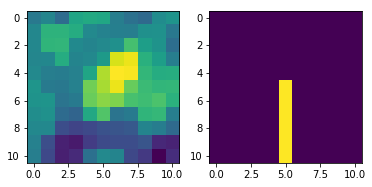

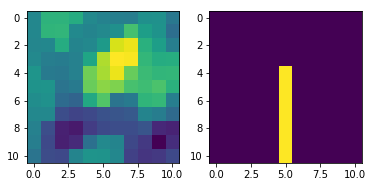

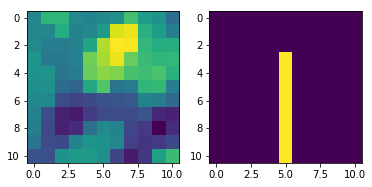

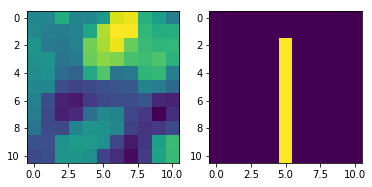

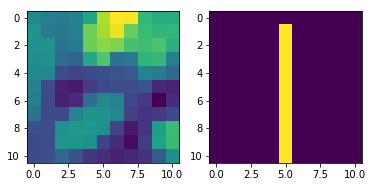

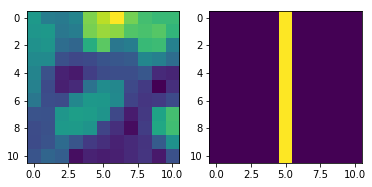

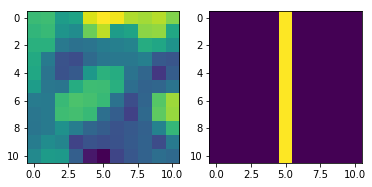

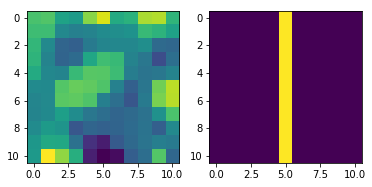

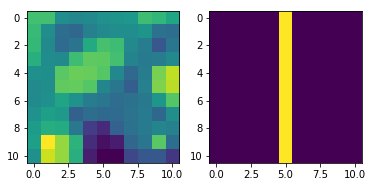

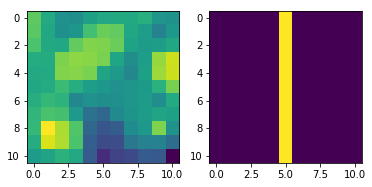

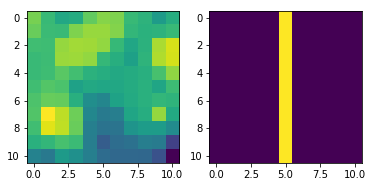

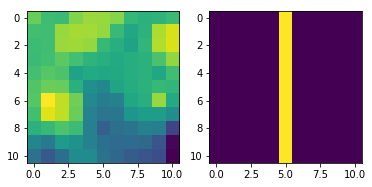

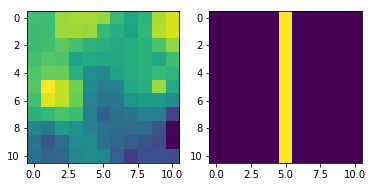

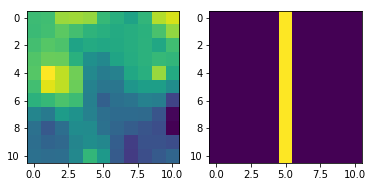

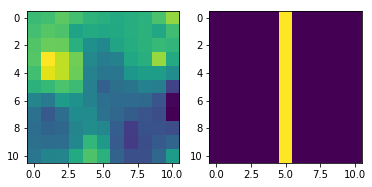

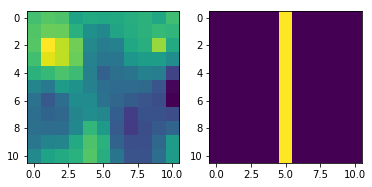

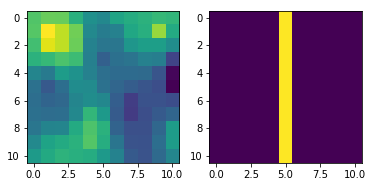

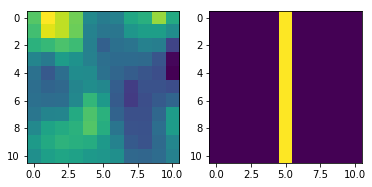

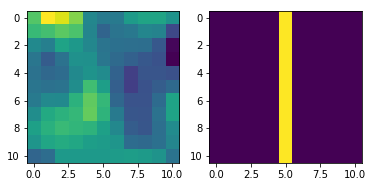

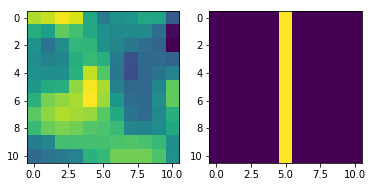

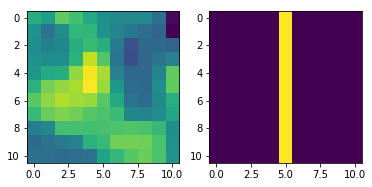

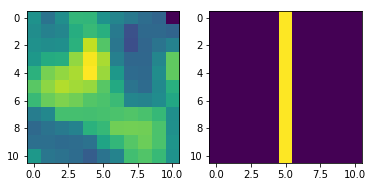

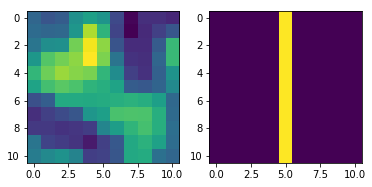

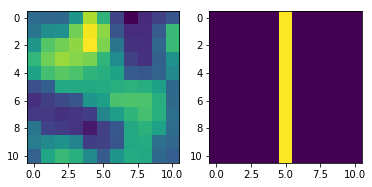

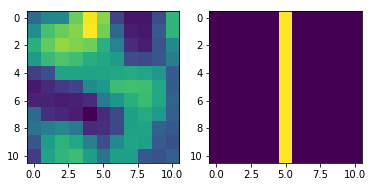

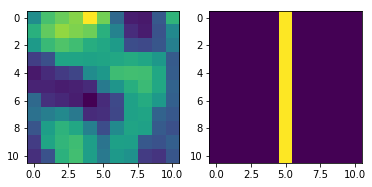

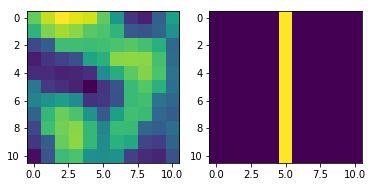

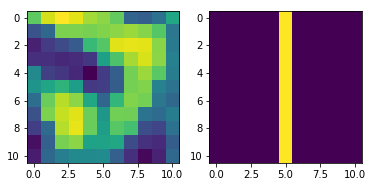

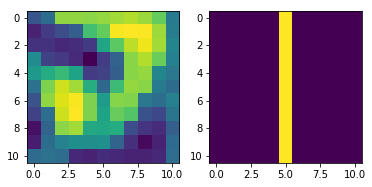

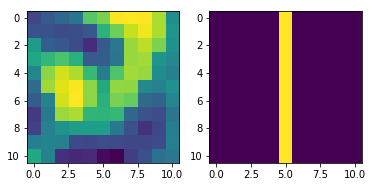

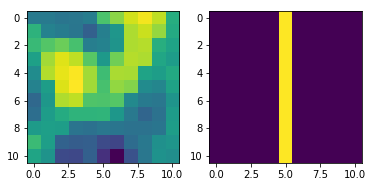

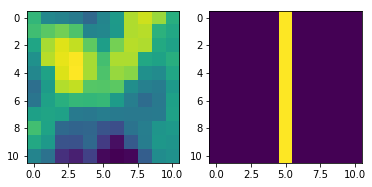

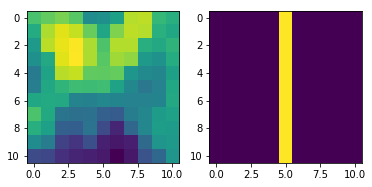

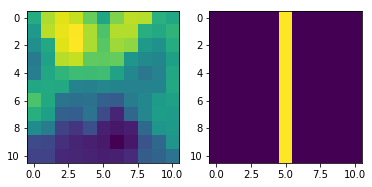

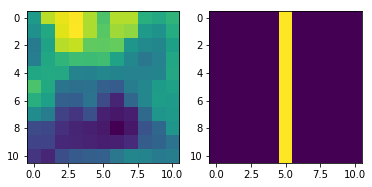

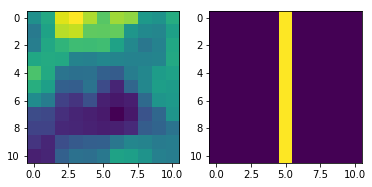

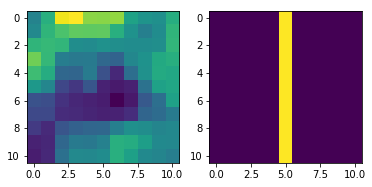

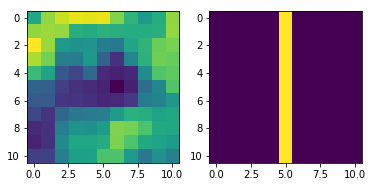

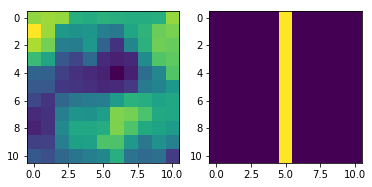

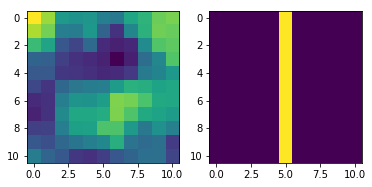

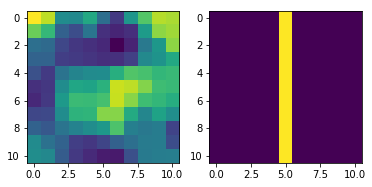

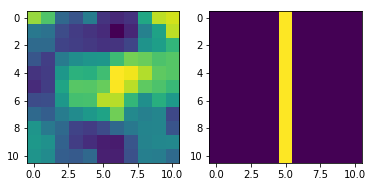

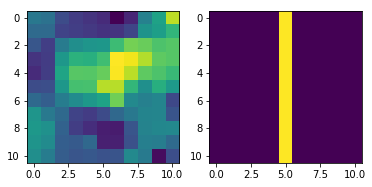

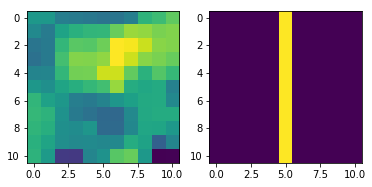

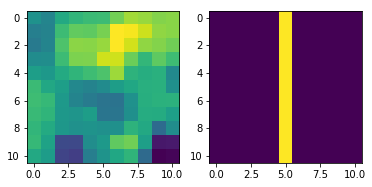

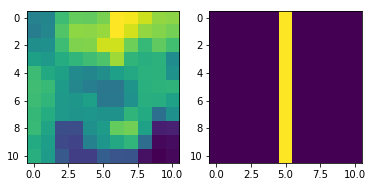

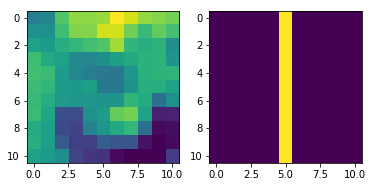

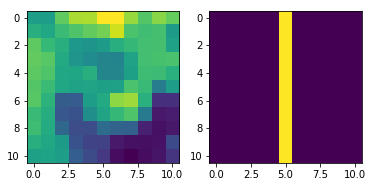

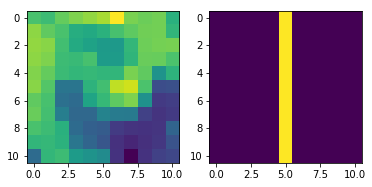

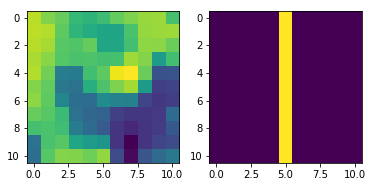

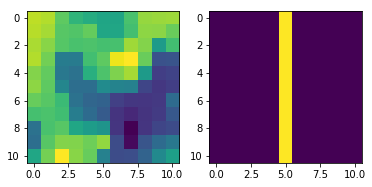

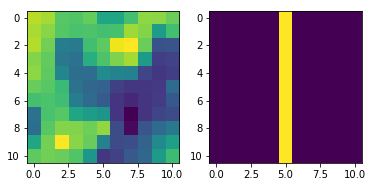

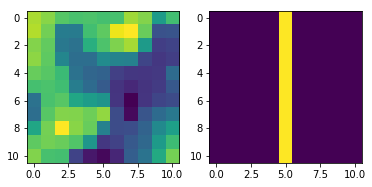

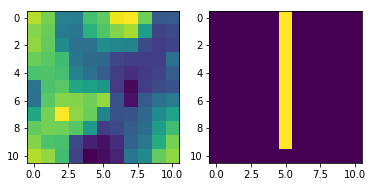

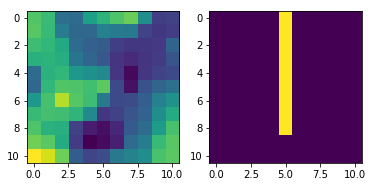

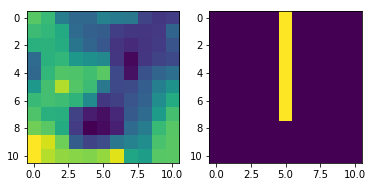

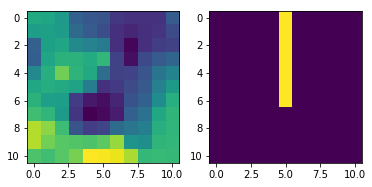

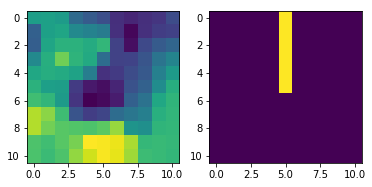

In [50]:
from matplotlib import pyplot as plt
plt.close("all")

for patch,mask in zip(patches,patchMasks):
    plt.figure()
    plt.subplot(121)
    plt.imshow(patch)
    plt.subplot(122)
    plt.imshow(mask)
    plt.show()